In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import copy
import pandas as pd
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools


sns.set_context('paper',font_scale=1.2)

In [2]:
import os
os.chdir('results')

In [3]:
class Plot_Arguments():
    def __init__(self):
        self.epochs = 100
        self.legends = ["Main task - Black box", "Main task - Model Replacement", "Attack success rate - black box",
                        "Attack success rate - model replacement"]
        self.maxy = 110
        self.ylabel = 'Accuracy (%)'
        self.xlabel = 'FL rounds'
        self.colors = ['black',
                       '#339933',
                       '#fdae61',
                       '#d7191c', '#000000', '#B03A2E', '#85C1E9']
        self.patterns = ['x', 'o', 'd', 'v', '^', '<', '>']

In [4]:
import numpy as np

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        
def generate_histogram(plot_config, experiment_name, y_label, column_name, min_y, max_y, average=False, display_err = True, extension="pdf", label_rotation=15):

    labels = []
    colors = []
    values = []
    errs = []
    
    for exp in plot_config["data"]:
        labels.append(exp["exp_name"])
        colors.append(exp["color"])
        if exp["file_path"] is None:

            values.append(min_y)

            errs.append(0)
        else:
            if average:
                max_value, std_dev = get_max_average(exp["file_path"],column_name)
                values.append(max_value)
                errs.append(std_dev)
            else:
                values.append(get_max_avg_value(exp["file_path"],column_name))
                errs.append(get_std_dev_value(exp["file_path"], column_name))
        
    # the histogram of the data
    print(errs)
    plot_args = Plot_Arguments()
    ax = sns.barplot(x = labels,y =values, palette = 'magma_r',yerr=errs, ci=385, capsize=1.5,)

    plot_args.ylabel= y_label

    ax.set_ylabel(plot_args.ylabel, fontsize=15)
    
    ax.tick_params(labelrotation=label_rotation)

    num_locations = 1
    hatches = itertools.cycle(['/',  '-', '//', '\\', '', 'o', 'O', '.'])
    for i, bar in enumerate(ax.patches):
        if i % num_locations == 0:
            hatch = next(hatches)
        bar.set_hatch(hatch)

    for i in ax.containers:
        try:
            ax.bar_label(i,[np.round(z,2) if z != min_y else "N/A" for z in values])
        except:
            pass
    
    new_value = 0.4
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        
    ax.set(ylim=(min_y, max_y))
    ax.set_xlabel('')
    ax.set_title('')
    plt.savefig('./figures/{}_{}.{}'.format(plot_config['dataset_name'], experiment_name, extension),bbox_inches='tight')

    plt.show()
    

In [5]:
def generate_xy_plot(plot_config, experiment_name, y_label, column_name, min_y, max_y, average=False):
    
    labels = []
    colors = []
    values = []
    markers = []
    
    for exp in plot_config["data"]:
        
        if exp["file_path"] is None:
            continue
            
        labels.append(exp["exp_name"])
        colors.append(exp["color"])
        markers.append(exp["symbol"])
        if average:
            values.append(compute_average_per_round(exp["file_path"],column_name))
        else:
            values.append(get_max_avg_value(exp["file_path"],column_name))
    
    
    plot_args = Plot_Arguments()
    fig, ax = plt.subplots()
    plot_args.ylabel= y_label

    x = range(1, len(values[0]) + 1)
    
    for i in range(len(labels)):
        print(labels[i])
        print(len(values[i]))
        ax.plot(x, values[i], color= colors[i] ,label=labels[i], linewidth=1, marker=markers[i], markersize=6, markevery=5+i)
            
    plt.ylabel(plot_args.ylabel)
    plt.xlabel(plot_args.xlabel)
    change_width(ax, .2)
    # plt.subplots_adjust(top=0.75)
    lgd = ax.legend(ncol=3, loc="lower center", bbox_to_anchor=[0.5, -0.55])
    ax.set_xlim(1, len(values[0])+1)
    ax.set_ylim(0, 100)
    
    plt.savefig('./figures/{}_{}.pdf'.format(plot_config['dataset_name'], experiment_name),bbox_inches='tight')

    plt.show()
    

        

In [6]:
def generate_tradeoff_plot(plot_config, experiment_name, x_label, y_label, x_column_name, y_column_name, min_y, max_y, min_x, max_x, average=False):
    
    labels = []
    colors = []
    values = []
    markers = []
    x_values = []
    y_values = []
    
    for exp in plot_config["data"]:
        if exp["file_path"] is None:
            continue
        labels.append(exp["exp_name"])
        colors.append(exp["color"])
        markers.append(exp["symbol"])
        if average:
            x_values.append(get_max_average(exp["file_path"],x_column_name))
            y_values.append(get_max_average(exp["file_path"],y_column_name))
        else:
            x_values.append(get_max_avg_value(exp["file_path"],x_column_name))
            y_values.append(get_max_avg_value(exp["file_path"],y_column_name))

        
    
    x_axis = [x for (x,_) in x_values]
    y_axis = [x for (x,_) in y_values]
    plot_args = Plot_Arguments()
    fig, ax = plt.subplots()
    plot_args.xlabel = x_label
    plot_args.ylabel= y_label
    
    ax = sns.scatterplot(x=x_axis, y= y_axis, hue=labels, style=labels,s=200, palette='magma_r')

    handles, labels  =  ax.get_legend_handles_labels()

    ax.legend(handles, labels,markerscale=1.5)

    ax.set_ylabel(y_label, fontsize=15)
    ax.set_xlabel(x_label)
    ax.set(ylim=(min_y, max_y), xlim=( min_x, max_x))

    
#     for i, txt in enumerate(labels):
#         ax.annotate(txt, (x_values[i] + 2 , y_values[i] -1), fontsize=8)
    
    plt.savefig('./figures/{}_{}.pdf'.format(plot_config['dataset_name'], experiment_name),bbox_inches='tight')

    plt.show()
    

In [7]:
def compute_average_per_round(file_path, column_name):
    data = pd.read_csv(file_path)
    columns_to_aggregate = data.columns[data.columns.str.contains(column_name)]
    
    values = data[columns_to_aggregate].mean(axis=1)
    return values.to_list()

def compute_average(file_path, column_name):
    return compute_average_per_round(file_path, column_name)[-1]
   
    
def get_max_average(file_path, column_name):
    data = pd.read_csv(file_path)
    columns_to_aggregate = data.columns[data.columns.str.contains(column_name)]
    
    maxs = []
    for column in columns_to_aggregate:
        maxs.append(max(data[column].to_list()))
        
    std_dev = np.std(maxs)
    
    return sum(maxs)/len(maxs), std_dev

def get_max_values_per_client(file_path, column_name):
    
    data = pd.read_csv(file_path)
    values = []
    
    columns_to_compute = data.columns[data.columns.str.contains(column_name)]
    
    for column in columns_to_compute:
        values.append(max(data[column].to_list()))
        
    return values



def get_max_avg_value(file_path, column_name):
    data = pd.read_csv(file_path)
    columns_to_aggregate = data.columns[data.columns.str.contains(column_name)]
    
    values = data[columns_to_aggregate].mean(axis=1)
    return sum(values.to_list()[-10:])/10


def get_std_dev_value(file_path, column_name):
    data = pd.read_csv(file_path)
    columns_to_aggregate = data.columns[data.columns.str.contains(column_name)]
    
    values = data[columns_to_aggregate].std(axis=1)
    return values.to_list()[-1]


In [8]:
def plot_xy(plot_config, experiment_name, y_label, column_name, min_y, max_y, average=False):
    
    labels = []
    colors = []
    values = []
    markers = []

    for exp in plot_config["data"]:

        if exp["file_path"] is None:
            continue

        labels.append(exp["exp_name"])
        colors.append(exp["color"])
        markers.append(exp["symbol"])
        if average:
            values.append(compute_average_per_round(exp["file_path"],column_name))
        else:
            values.append(get_column(exp["file_path"],column_name))


    plot_args = Plot_Arguments()
    fig, ax = plt.subplots()
    plot_args.ylabel= y_label

    #x = range(1, len(values[0]) + 1)


    df = pd.DataFrame(values)
    df = df.transpose()
    df.set_axis(labels, axis=1, inplace=True)




    sns.lineplot(data=df,palette='magma_r',markers=True, dashes=False)

    plt.ylabel(plot_args.ylabel)
    plt.xlabel(plot_args.xlabel)
    change_width(ax, .2)
    # plt.subplots_adjust(top=0.75)
    lgd = ax.legend(ncol=3, loc="lower center", bbox_to_anchor=[0.5, -0.55])
    #ax.set_xlim(1, len(values[0]))
    ax.set_ylim(0, max_y)

    plt.savefig('./figures/{}_{}.pdf'.format(plot_config['dataset_name'], experiment_name),bbox_inches='tight')

    plt.show()

## CIFAR-10 Resnet

In [46]:
plot_config = {
                "dataset_name": "cifar_resnet",
                "dataset_pretty_name" : "CIFAR10",

                "data":[
                        {
                            "exp_name" : "No defense",
                            "file_path": "resnet_ppm_baseline_cifar.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
                    
                        
                         {
                            "exp_name" : "RelaxLoss",
                            "file_path": "resnet_ppm_cifar_relaxloss.csv",
                            "color": "red",
                            "symbol" : ">"
                        },
                                                                                             {
                            "exp_name" : "ANL",
                            "file_path": "resnet_ppm_ANL_cifar.csv",
                            "color": "magenta",
                            "symbol" : "X"
                        },
                                                                     {
                            "exp_name" : "GNL",
                            "file_path": "resnet_ppm_gnl_cifar.csv",
                            "color": "lime",
                            "symbol" : "H"
                        },

                    {
                            "exp_name" : "PASTEL",
                            "file_path": "resnet_ppm_bn17_cifar.csv",
                            "color": "grey",
                            "symbol" : "*"
                        },
                                        
                                              
                           
                            {
                            "exp_name" : "PASTEL + Flattening ",
                            "file_path": "ppm_posterior_flattening_relaxloss_uniform_cifar_resnet.csv",
                            "color": "brown",
                            "symbol" : "x"
                        }
                    ]
                }
            


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


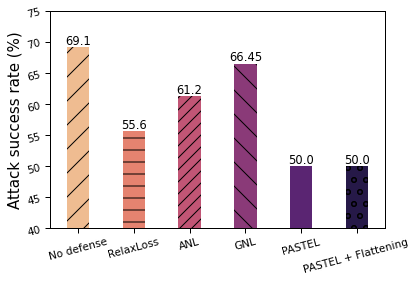

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


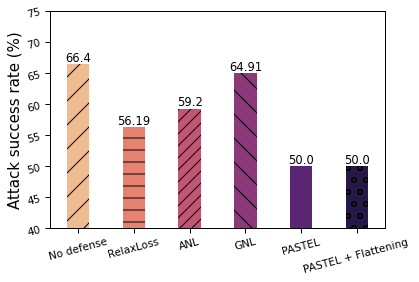

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


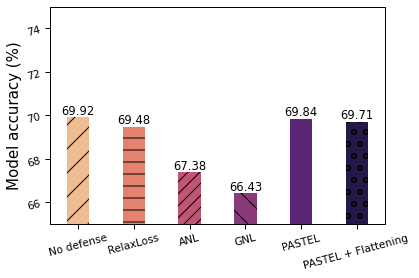

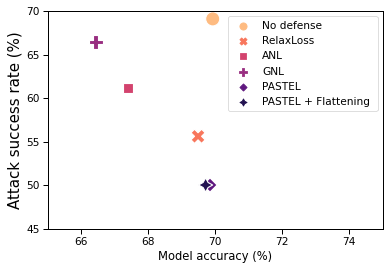

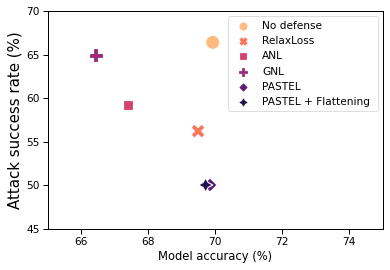

In [48]:
generate_histogram(plot_config, "local_model_attack_accuracy_hist", "Attack success rate (%)", "client_attack", 40, 75, average=True)
generate_histogram(plot_config, "global_model_attack_accuracy_hist", "Attack success rate (%)", "server_attack", 40, 75, average=True)
#generate_xy_plot(plot_config, 'local_models_attack_accuracy', 'Attack success rate (%)', 'client_attack', 0, 100, average=True)
#generate_xy_plot(plot_config, 'global_model_attack_accuracy', 'Attack success rate (%)', 'server_attack', 0, 100, average=True)
#generate_xy_plot(plot_config, 'local_models_accuracy', 'Model accuracy (%)', 'client_accuracy', 0, 100, average=True)
generate_histogram(plot_config, "local_models_accuracy_hist", "Model accuracy (%)", "client_accuracy", 65, 75, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy', 'client_attack', 45, 70, 65, 75, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_server', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy', 'server_attack', 45, 70, 65, 75, average=True)


### Cifar 10 - VGG

In [49]:
plot_config = {
                "dataset_name": "cifar_vgg",
                "dataset_pretty_name" : "CIFAR10",

                "data":[
                        {
                            "exp_name" : "No defense",
                            "file_path": "resnet_ppm_baseline_cifar.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
                    
                                                                                             {
                            "exp_name" : "ANL",
                            "file_path": "vgg_ppm_ANL_cifar_vgg.csv",
                            "color": "magenta",
                            "symbol" : "X"
                        },
                        
                         {
                            "exp_name" : "RelaxLoss",
                            "file_path": "vgg_ppm_cifar_relaxloss_vgg.csv",
                            "color": "red",
                            "symbol" : ">"
                        },
                                                                     {
                            "exp_name" : "GNL",
                            "file_path": "vgg_ppm_gnl_cifar_vgg.csv",
                            "color": "lime",
                            "symbol" : "H"
                        },

                    {
                            "exp_name" : "PASTEL",
                            "file_path": "vgg_ppm_bn17_cifar_vgg.csv",
                            "color": "grey",
                            "symbol" : "*"
                        },
                                        
                                              
                           
                            {
                            "exp_name" : "PASTEL + Flattening ",
                            "file_path": "ppm_posterior_flattening_relaxloss_uniform_cifar_vgg.csv",
                            "color": "brown",
                            "symbol" : "x"
                        }
                    ]
                }
            


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


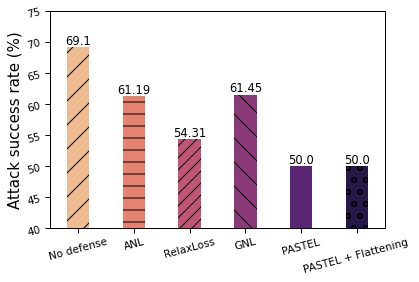

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


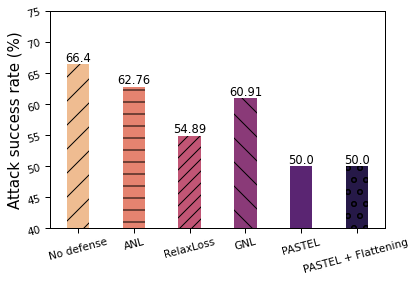

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


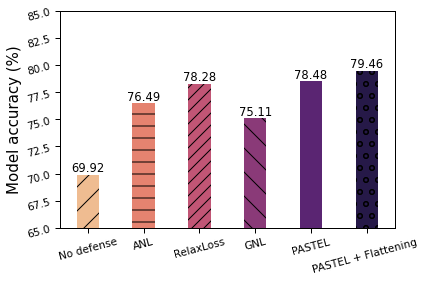

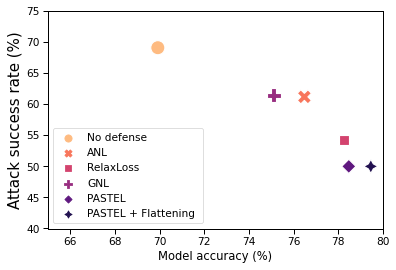

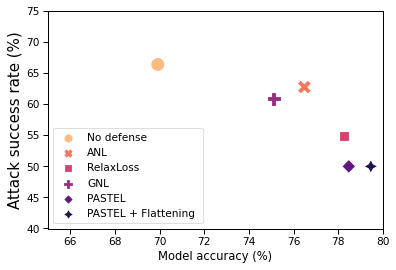

In [52]:
generate_histogram(plot_config, "local_model_attack_accuracy_hist", "Attack success rate (%)", "client_attack", 40, 75, average=True)
generate_histogram(plot_config, "global_model_attack_accuracy_hist", "Attack success rate (%)", "server_attack", 40, 75, average=True)
#generate_xy_plot(plot_config, 'local_models_attack_accuracy', 'Attack success rate (%)', 'client_attack', 0, 100, average=True)
#generate_xy_plot(plot_config, 'global_model_attack_accuracy', 'Attack success rate (%)', 'server_attack', 0, 100, average=True)
#generate_xy_plot(plot_config, 'local_models_accuracy', 'Model accuracy (%)', 'client_accuracy', 0, 100, average=True)
generate_histogram(plot_config, "local_models_accuracy_hist", "Model accuracy (%)", "client_accuracy", 65, 85, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy', 'client_attack', 40, 75, 65, 80, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_server', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy', 'server_attack', 40, 75, 65, 80, average=True)


### CIFAR 100 ResNet

In [57]:
plot_config = {
                "dataset_name": "cifar100_resnet",
                "dataset_pretty_name" : "CIFAR10",

                "data":[
                        {
                            "exp_name" : "No defense",
                            "file_path": "ppm_baseline_cifar100_resnet.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
                        
                         {
                            "exp_name" : "RelaxLoss",
                            "file_path": "ppm_cifar100_relaxloss_resnet.csv",
                            "color": "red",
                            "symbol" : ">"
                        },
                                                                                            {
                            "exp_name" : "ANL",
                            "file_path": "ppm_ANL_cifar100_resnet.csv",
                            "color": "magenta",
                            "symbol" : "X"
                        },
                                                                     {
                            "exp_name" : "GNL",
                            "file_path": "ppm_gnl_cifar100_resnet.csv",
                            "color": "lime",
                            "symbol" : "H"
                        },
 
                    {
                            "exp_name" : "PASTEL",
                            "file_path": "ppm_bn1_cifar100_resnet.csv",
                            "color": "grey",
                            "symbol" : "*"
                        },
                                        
                                              
                           
                            {
                            "exp_name" : "PASTEL + Flattening ",
                            "file_path": "ppm_posterior_flattening_relaxloss_uniform_cifar100_resnet.csv",
                            "color": "brown",
                            "symbol" : "x"
                        }
                    ]
                }
            


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


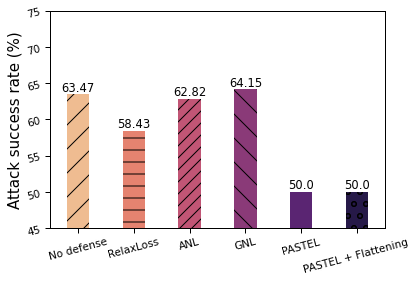

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


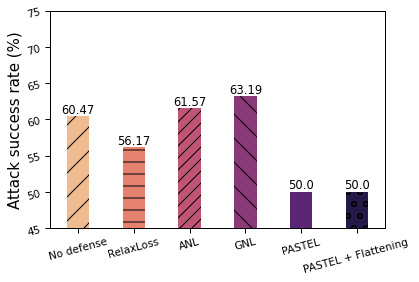

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


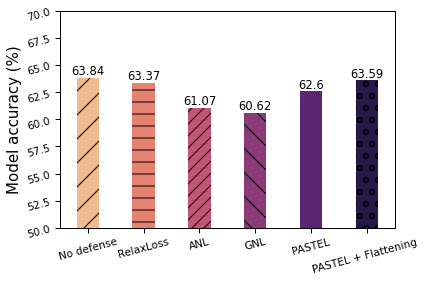

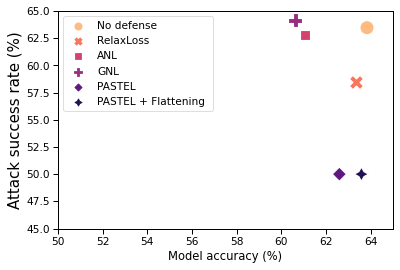

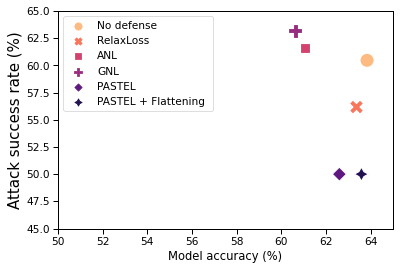

In [58]:
generate_histogram(plot_config, "local_model_attack_accuracy_hist", "Attack success rate (%)", "client_attack", 45, 75, average=True)
generate_histogram(plot_config, "global_model_attack_accuracy_hist", "Attack success rate (%)", "server_attack", 45, 75, average=True)
#generate_xy_plot(plot_config, 'local_models_attack_accuracy', 'Attack success rate (%)', 'client_attack', 0, 100, average=True)
#generate_xy_plot(plot_config, 'global_model_attack_accuracy', 'Attack success rate (%)', 'server_attack', 0, 100, average=True)
#generate_xy_plot(plot_config, 'local_models_accuracy', 'Model accuracy (%)', 'client_accuracy', 0, 100, average=True)
generate_histogram(plot_config, "local_models_accuracy_hist", "Model accuracy (%)", "client_accuracy", 50, 70, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy', 'client_attack', 45, 65, 50, 65, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_server', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy', 'server_attack', 45, 65, 50, 65, average=True)


### CIFAR 100 VGG

In [59]:
plot_config = {
                "dataset_name": "cifar100_vgg",
                "dataset_pretty_name" : "CIFAR10",

                "data":[
                        {
                            "exp_name" : "No defense",
                            "file_path": "vgg_ppm_baseline_cifar100_vgg.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
                        
                         {
                            "exp_name" : "RelaxLoss",
                            "file_path": "vgg_ppm_cifar100_relaxloss_vgg.csv",
                            "color": "red",
                            "symbol" : ">"
                        },
                                                                                            {
                            "exp_name" : "ANL",
                            "file_path": "vgg_ppm_ANL_cifar100_vgg.csv",
                            "color": "magenta",
                            "symbol" : "X"
                        },
                                                                     {
                            "exp_name" : "GNL",
                            "file_path": "vgg_ppm_gnl_cifar100_vgg.csv",
                            "color": "lime",
                            "symbol" : "H"
                        },
 
                    {
                            "exp_name" : "PASTEL",
                            "file_path": "vgg_ppm_bn17_cifar100_vgg.csv",
                            "color": "grey",
                            "symbol" : "*"
                        },
                                        
                                              
                           
                            {
                            "exp_name" : "PASTEL + Flattening ",
                            "file_path": "ppm_posterior_flattening_relaxloss_uniform_cifar100_vgg.csv",
                            "color": "brown",
                            "symbol" : "x"
                        }
                    ]
                }
            


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


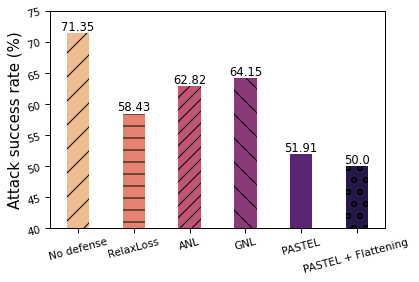

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


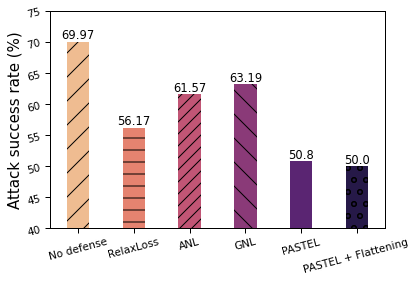

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


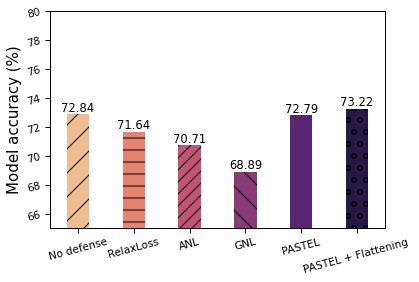

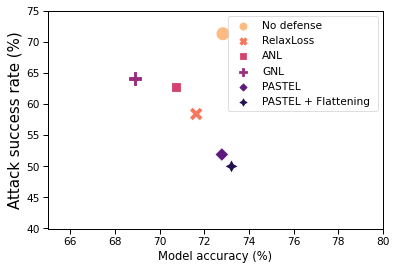

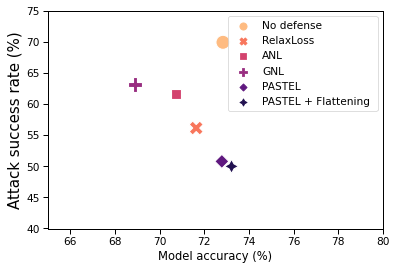

In [60]:
generate_histogram(plot_config, "local_model_attack_accuracy_hist", "Attack success rate (%)", "client_attack", 40, 75, average=True)
generate_histogram(plot_config, "global_model_attack_accuracy_hist", "Attack success rate (%)", "server_attack", 40, 75, average=True)
#generate_xy_plot(plot_config, 'local_models_attack_accuracy', 'Attack success rate (%)', 'client_attack', 0, 100, average=True)
#generate_xy_plot(plot_config, 'global_model_attack_accuracy', 'Attack success rate (%)', 'server_attack', 0, 100, average=True)
#generate_xy_plot(plot_config, 'local_models_accuracy', 'Model accuracy (%)', 'client_accuracy', 0, 100, average=True)
generate_histogram(plot_config, "local_models_accuracy_hist", "Model accuracy (%)", "client_accuracy", 65, 80, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy', 'client_attack', 40, 75, 65, 80, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_server', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy', 'server_attack', 40, 75, 65, 80, average=True)


### Speech Commands

In [17]:
plot_config = {
                "dataset_name": "speechcommands",
                "dataset_pretty_name" : "Speech Commands",

                "data":[
                        {
                            "exp_name" : "No defense",
                            "file_path": "ppm_baseline_speechcommands.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
                        
                         {
                            "exp_name" : "RelaxLoss",
                            "file_path": "ppm_speechcommands_relaxloss.csv",
                            "color": "red",
                            "symbol" : ">"
                        },
                                                                                             {
                            "exp_name" : "ANL",
                            "file_path": "ppm_ANL_speechcommands.csv",
                            "color": "magenta",
                            "symbol" : "X"
                        },
                                                                     {
                            "exp_name" : "GNL",
                            "file_path": "ppm_gnl_speechcommands.csv",
                            "color": "lime",
                            "symbol" : "H"
                        },

                    {
                            "exp_name" : "PASTEL",
                            "file_path": "ppm_posterior_flattening_relaxloss_uniform_speech_commands.csv",
                            "color": "grey",
                            "symbol" : "*"
                        },
                                        
                                              
                           
                            {
                            "exp_name" : "PASTEL + Flattening ",
                            "file_path": "ppm_bn17_speechcommands.csv",
                            "color": "brown",
                            "symbol" : "x"
                        }
                    ]
                }
            


[0.5447452660136589, 1.3446806646804275, 0.7888496289054174, 0.5811336016578083, 0.0, 0.0]


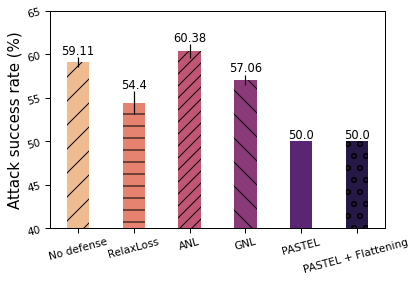

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


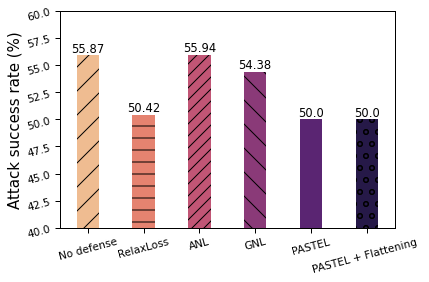

[0.25503882668111505, 0.9690004838575988, 0.0986405819046857, 0.40524729741832505, 0.4168919392579384, 0.19899046187899994]


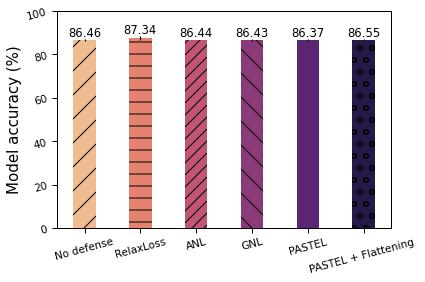

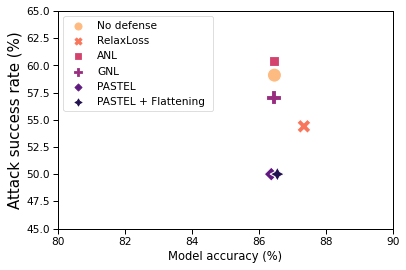

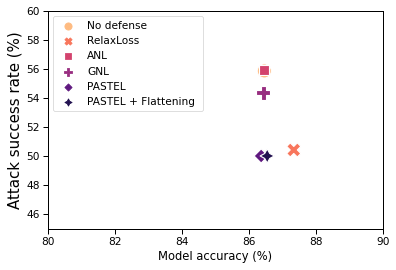

In [18]:
generate_histogram(plot_config, "local_model_attack_accuracy_hist", "Attack success rate (%)", "client_attack", 40, 65, average=True)
generate_histogram(plot_config, "global_model_attack_accuracy_hist", "Attack success rate (%)", "server_attack", 40, 60, average=True)
#generate_xy_plot(plot_config, 'local_models_attack_accuracy', 'Attack success rate (%)', 'client_attack', 0, 100, average=True)
#generate_xy_plot(plot_config, 'global_model_attack_accuracy', 'Attack success rate (%)', 'server_attack', 0, 100, average=True)
#generate_xy_plot(plot_config, 'local_models_accuracy', 'Model accuracy (%)', 'client_accuracy', 0, 100, average=True)
generate_histogram(plot_config, "local_models_accuracy_hist", "Model accuracy (%)", "client_accuracy", 0, 100, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy', 'client_attack', 45, 65, 80, 90, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_server', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy', 'server_attack', 45, 60, 80, 90, average=True)


### Purchase 100

In [19]:
plot_config = {
                "dataset_name": "Purchase _100",
                "dataset_pretty_name" : "Purchase 100",

                "data":[

                        {
                            "exp_name" : "No defense",
                            "file_path": "ppm_baseline_purchase.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
                           
                           
                            
                               {
                            "exp_name" : "RelaxLoss",
                            "file_path": "ppm_relaxloss_purchase.csv",
                            "color": "red",
                            "symbol" : ">"
                        },
                    
                                                            
                                                                     {
                            "exp_name" : "ANL",
                            "file_path": None,
                            "color": "lime",
                            "symbol" : "H"
                        },
                                                                     {
                            "exp_name" : "GNL",
                            "file_path": "ppm_gnl_purchase.csv",
                            "color": "lime",
                            "symbol" : "H"
                        },
                           
                            {
                            "exp_name" : "PASTEL",
                            "file_path": "ppm_pastel_purchase.csv",
                            "color": "brown",
                            "symbol" : "x"
                        },                                               

                                              
                           
                            {
                            "exp_name" : "PASTEL + Flattening ",
                            "file_path": "ppm_posterior_flattening_relaxloss_uniform_purchase.csv",
                            "color": "brown",
                            "symbol" : "x"
                        }
                    
                    
                    ]
                }

[1.220509694302485, 1.2121212121212117, 0, 2.2450616940295838, 0.588985039883366, 1.6720146825501878]


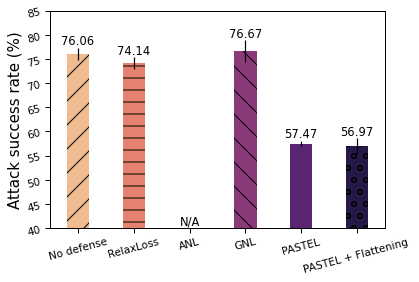

[0.0, 0.0, 0, 0.0, 0.0, 0.0]


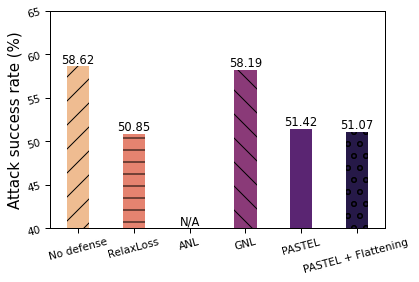

[0.1991991647522942, 0.1608500662872697, 0, 0.49349682723544824, 0.2972682388781398, 0.11177010948379922]


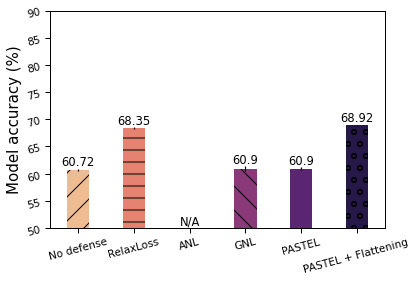

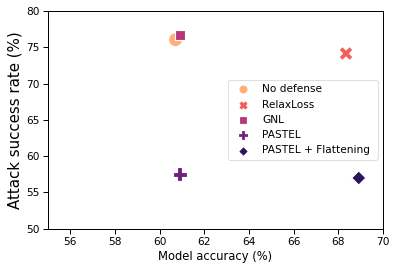

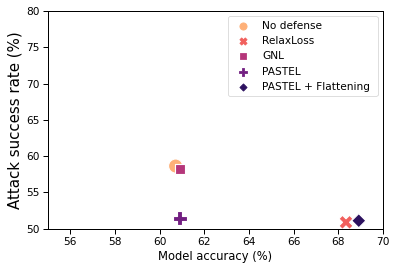

In [20]:
generate_histogram(plot_config, "local_model_attack_accuracy_hist", "Attack success rate (%)", "client_attack", 40, 85, average=True)
generate_histogram(plot_config, "global_model_attack_accuracy_hist", "Attack success rate (%)", "server_attack", 40, 65, average=True)
#generate_xy_plot(plot_config, 'local_models_attack_accuracy', 'Attack success rate (%)', 'client_attack', 0, 100, average=True)
#generate_xy_plot(plot_config, 'global_model_attack_accuracy', 'Attack success rate (%)', 'server_attack', 0, 100, average=True)
#generate_xy_plot(plot_config, 'local_models_accuracy', 'Model accuracy (%)', 'client_accuracy', 40, 70, average=True)
generate_histogram(plot_config, "local_models_accuracy_hist", "Model accuracy (%)", "client_accuracy", 50, 90, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy', 'client_attack', 50, 80, 55, 70, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_server', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy', 'server_attack', 50, 80, 55, 70, average=True)


### Texas 100

In [21]:
plot_config = {
                "dataset_name": "Texas_100",
                "dataset_pretty_name" : "Texas100",

                "data":[

                        {
                            "exp_name" : "No defense",
                            "file_path": "ppm_baseline_texas.csv",
                            "color": "black",
                            "symbol" : "+"
                        },

                                                                     {
                            "exp_name" : "RelaxLoss",
                            "file_path": "ppm_relaxloss_texas.csv",
                            "color": "red",
                            "symbol" : ">"
                        },
                                        
                                                                     {
                            "exp_name" : "ANL",
                            "file_path": None,
                            "color": "lime",
                            "symbol" : "H"
                        },
                    
                                                                     {
                            "exp_name" : "GNL",
                            "file_path": "ppm_gnl_texas.csv",
                            "color": "lime",
                            "symbol" : "H"
                        },
                            
                          
                                                 {
                            "exp_name" : "PASTEL",
                            "file_path": "ppm_linear1_texas.csv",
                            "color": "brown",
                            "symbol" : "x"
                        },
                                               
                            {
                            "exp_name" : "PASTEL + Flattening ",
                            "file_path": "ppm_posterior_flattening_relaxloss_uniform_texas.csv",
                            "color": "brown",
                            "symbol" : "x"
                        }
                    ]
                }

[2.5100344440033706, 1.072795669590865, 0, 3.001005289767079, 1.446275268294576, 1.1258754453886821]


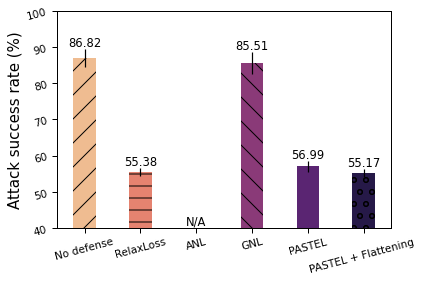

[0.0, 0.0, 0, 0.0, 0.0, 0.0]


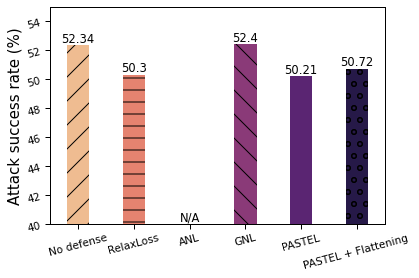

[0.5053858118865474, 4.602092875384904, 0, 0.31192105750210264, 0.21309751517642872, 0.12124273975047617]


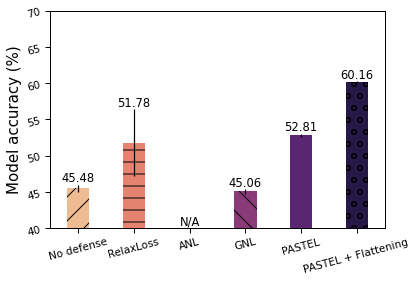

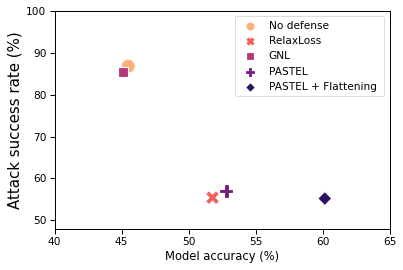

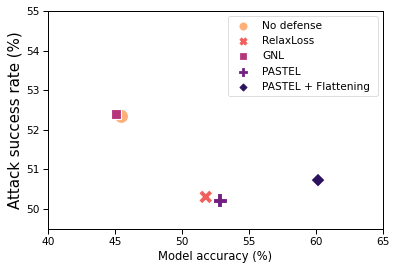

In [22]:
generate_histogram(plot_config, "local_model_attack_accuracy_hist", "Attack success rate (%)", "client_attack", 40, 100, average=True)
generate_histogram(plot_config, "global_model_attack_accuracy_hist", "Attack success rate (%)", "server_attack", 40, 55, average=True)
#generate_xy_plot(plot_config, 'local_models_attack_accuracy', 'Attack success rate (%)', 'client_attack', 0, 80, average=True)
#generate_xy_plot(plot_config, 'global_model_attack_accuracy', 'Attack success rate (%)', 'server_attack', 0, 60, average=True)
#generate_xy_plot(plot_config, 'local_models_accuracy', 'Model accuracy (%)', 'client_accuracy', 35, 50, average=True)
generate_histogram(plot_config, "local_models_accuracy_hist", "Model accuracy (%)", "client_accuracy", 40, 70, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy', 'client_attack', 48, 100, 40, 65, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_server', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy', 'server_attack',49.5, 55, 40, 65, average=True)


### Celeba VGG

In [23]:
plot_config = {
                "dataset_name": "celeba_vgg",
                "dataset_pretty_name" : "CelebA",

                "data":[

                        {
                            "exp_name" : "No defense",
                            "file_path": "ppm_baseline_celeba_vgg.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
                            
                                           {
                            "exp_name" : "Relaxloss",
                            "file_path": "ppm_relaxloss_celeba_vgg.csv",
                            "color": "red",
                            "symbol" : ">"
                        },
                                                                                             {
                            "exp_name" : "ANL",
                            "file_path": "ppm_anl_celeba_vgg.csv",
                            "color": "magenta",
                            "symbol" : "X"
                        },

                                                                     {
                            "exp_name" : "GNL",
                            "file_path": "ppm_gnl_celeba_vgg.csv",
                            "color": "lime",
                            "symbol" : "H"
                        },

                                                            {
                            "exp_name" : "PASTEL",
                            "file_path": "ppm_last-bn_celeba_vgg.csv",
                            "color": "grey",
                            "symbol" : "*"
                        },
                                               
                            {
                            "exp_name" : "PASTEL + Flattening ",
                            "file_path": "ppm_posterior_flattening_relaxloss_uniform_celeba_vgg.csv",
                            "color": "brown",
                            "symbol" : "x"
                        }


                    ]
                }

[1.7333333333333347, 0.7774602526460419, 1.218377792166472, 1.0954451150103328, 1.282358937444759, 0.0]


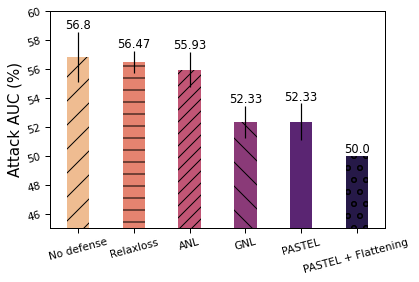

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


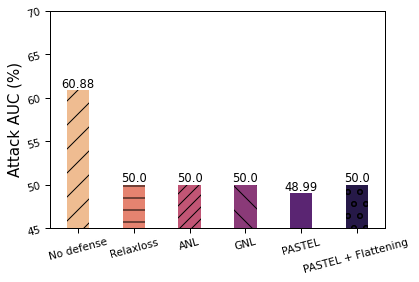

[0.3241508565124838, 0.5364575161806082, 0.3054002837807015, 0.9482090721167142, 0.27835708481493127, 0.6130202099260524]


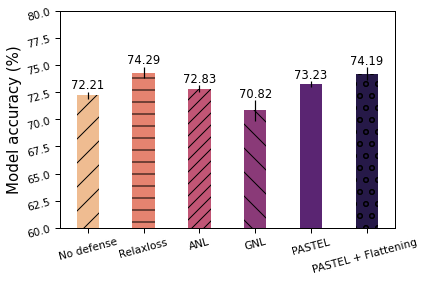

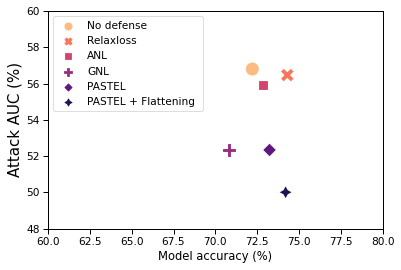

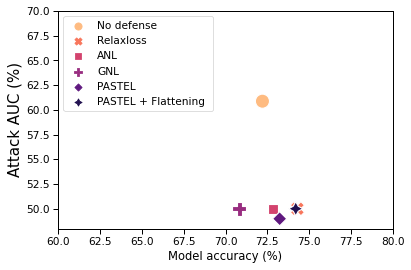

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


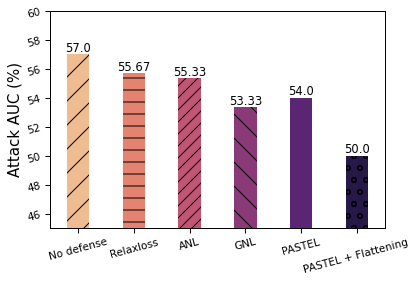

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


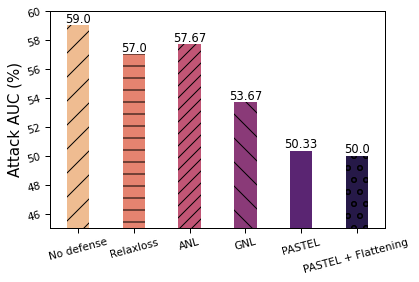

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


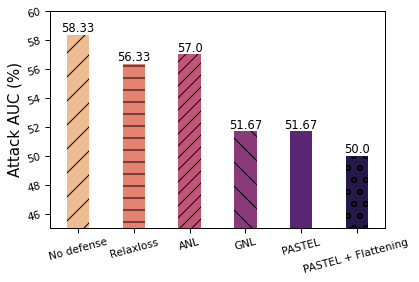

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


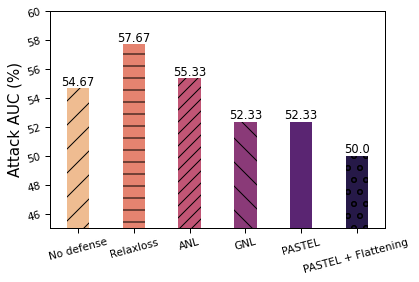

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


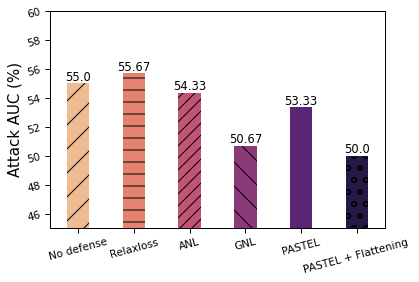

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


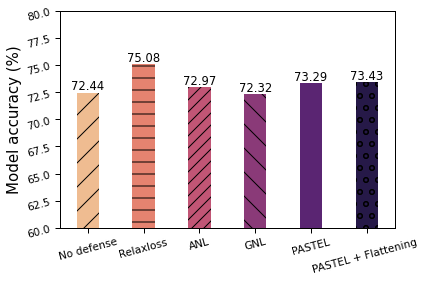

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


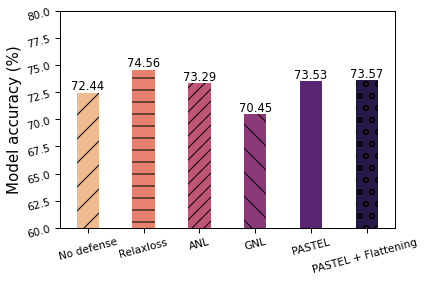

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


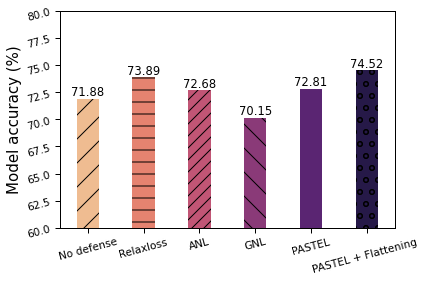

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


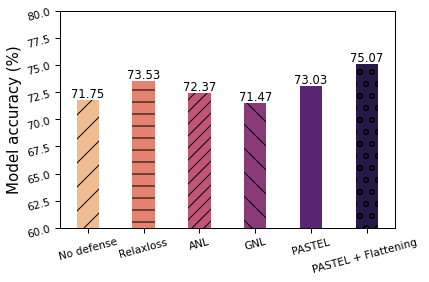

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


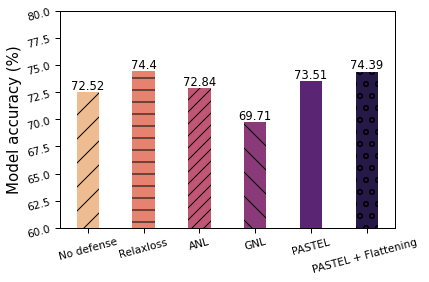

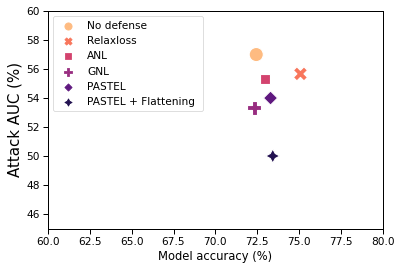

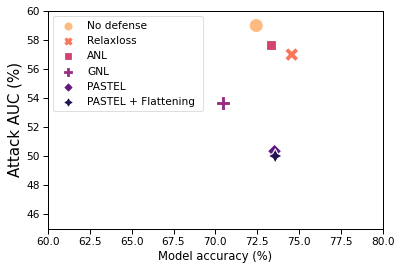

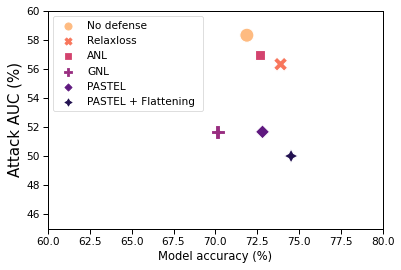

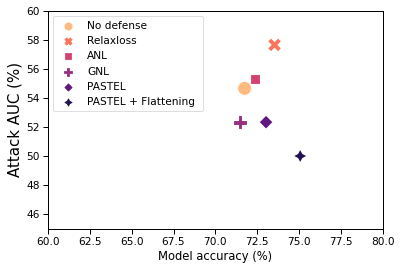

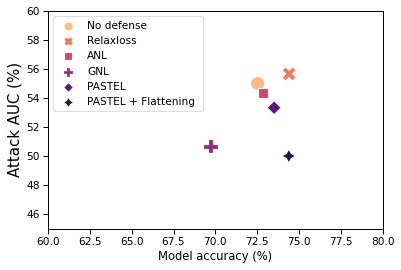

In [24]:
generate_histogram(plot_config, "local_model_attack_accuracy_hist", "Attack AUC (%)", "client_auc", 45, 60, average=True)
generate_histogram(plot_config, "global_model_attack_accuracy_hist", "Attack AUC (%)", "server_attack", 45, 70, average=True)
#generate_xy_plot(plot_config, 'local_models_attack_accuracy', 'Attack AUC (%)', 'client_auc', 0, 100, average=True)
#generate_xy_plot(plot_config, 'global_model_attack_accuracy', 'Attack AUC (%)', 'server_attack', 0, 100, average=True)
#generate_xy_plot(plot_config, 'local_models_accuracy', 'Model accuracy (%)', 'client_accuracy', 0, 102, average=True)
generate_histogram(plot_config, "local_models_accuracy_hist", "Model accuracy (%)", "client_accuracy", 60, 80, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy', 'client_auc', 48, 60, 60, 80, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_server', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy', 'server_attack', 48, 70, 60, 80, average=True)

generate_histogram(plot_config, "local_model_0_attack_accuracy_hist", "Attack AUC (%)", "client_auc_0", 45, 60, average=True, extension = "png")
generate_histogram(plot_config, "local_model_1_attack_accuracy_hist", "Attack AUC (%)", "client_auc_1", 45, 60, average=True, extension = "png")
generate_histogram(plot_config, "local_model_2_attack_accuracy_hist", "Attack AUC (%)", "client_auc_2", 45, 60, average=True, extension = "png")
generate_histogram(plot_config, "local_model_3_attack_accuracy_hist", "Attack AUC (%)", "client_auc_3", 45, 60, average=True, extension = "png")
generate_histogram(plot_config, "local_model_4_attack_accuracy_hist", "Attack AUC (%)", "client_auc_4", 45, 60, average=True, extension = "png")


generate_histogram(plot_config, "local_model_0_accuracy_hist", "Model accuracy (%)", "client_accuracy_0", 60, 80, average=True, extension = "png")
generate_histogram(plot_config, "local_model_1_accuracy_hist", "Model accuracy (%)", "client_accuracy_1", 60, 80, average=True, extension = "png")
generate_histogram(plot_config, "local_model_2_accuracy_hist", "Model accuracy (%)", "client_accuracy_2", 60, 80, average=True, extension = "png")
generate_histogram(plot_config, "local_model_3_accuracy_hist", "Model accuracy (%)", "client_accuracy_3", 60, 80, average=True, extension = "png")
generate_histogram(plot_config, "local_model_4_accuracy_hist", "Model accuracy (%)", "client_accuracy_4", 60, 80, average=True, extension = "png")

generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client1', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy_0', 'client_auc_0', 45, 60, 60, 80, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client2', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy_1', 'client_auc_1', 45, 60, 60, 80, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client3', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy_2', 'client_auc_2', 45, 60, 60, 80, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client4', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy_3', 'client_auc_3', 45, 60, 60, 80, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client5', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy_4', 'client_auc_4', 45, 60, 60, 80, average=True)



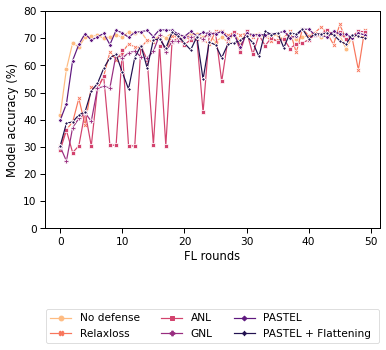

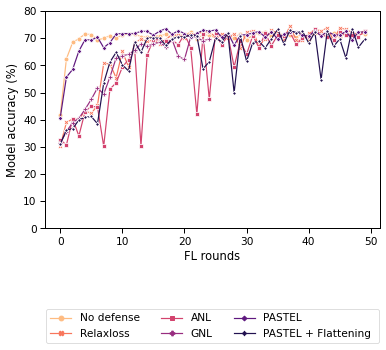

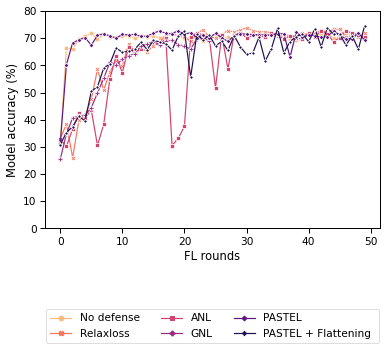

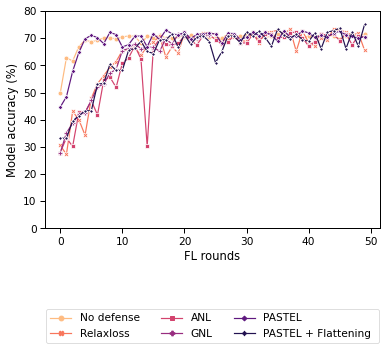

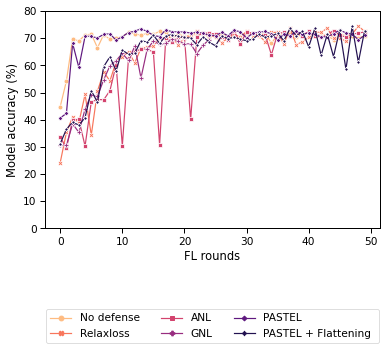

In [25]:
plot_xy(plot_config, 'client_accuracy_0', 'Model accuracy (%)', 'client_accuracy_0', 0, 80, average=True)
plot_xy(plot_config, 'client_accuracy_1', 'Model accuracy (%)', 'client_accuracy_1', 0, 80, average=True)
plot_xy(plot_config, 'client_accuracy_2', 'Model accuracy (%)', 'client_accuracy_2', 0, 80, average=True)
plot_xy(plot_config, 'client_accuracy_3', 'Model accuracy (%)', 'client_accuracy_3', 0, 80, average=True)
plot_xy(plot_config, 'client_accuracy_4', 'Model accuracy (%)', 'client_accuracy_4', 0, 80, average=True)

### CelebA ResNet20

In [26]:
plot_config = {
                "dataset_name": "celeba_resnet",
                "dataset_pretty_name" : "CelebA_ResNet",

                "data":[

                        {
                            "exp_name" : "No defense",
                            "file_path": "ppm_baseline_celeba_resnet.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
                         {
                            "exp_name" : "Relaxloss",
                            "file_path": "ppm_relaxloss01_celeba_resnet.csv",
                            "color": "red",
                            "symbol" : ">"
                        },
                                                                                             {
                            "exp_name" : "ANL",
                            "file_path": "ppm_anl_celeba_resnet.csv",
                            "color": "magenta",
                            "symbol" : "X"
                        },

                                                                     {
                            "exp_name" : "GNL",
                            "file_path": "ppm_gnl_celeba_resnet.csv",
                            "color": "lime",
                            "symbol" : "H"
                        },


                     {
                            "exp_name" : "PASTEL",
                            "file_path": "ppm_pastel2_celeba_resnet.csv",
                            "color": "grey",
                            "symbol" : "*"
                        },
                                               
                            {
                            "exp_name" : "PASTEL + Flattening ",
                            "file_path": "ppm_posterior_flattening_relaxloss_uniform_celeba_resnet.csv",
                            "color": "brown",
                            "symbol" : "x"
                        }
                            
                    ]
                }

[0.33993463423951864, 1.316561177208769, 1.7962924780409941, 2.135415650406259, 0.0, 0.0]


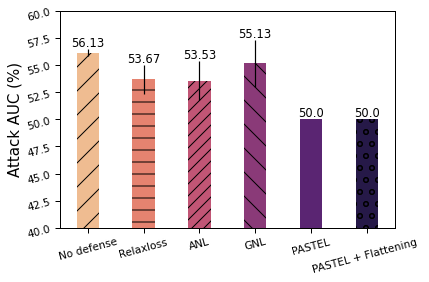

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


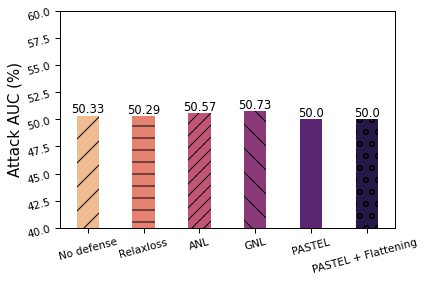

[0.6212474904934768, 0.7012167203432106, 0.3828687039240014, 0.3296327923277349, 0.6084442821199343, 0.25284162807751603]


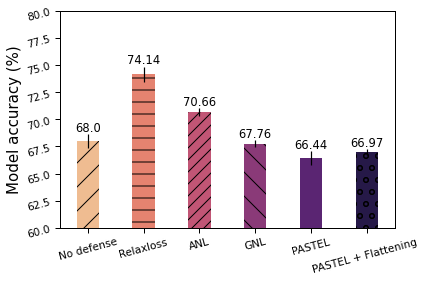

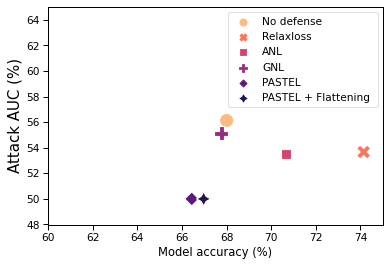

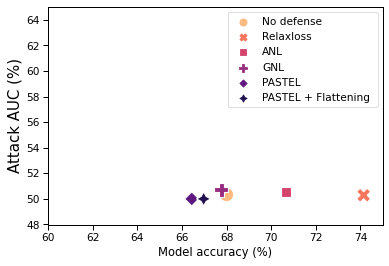

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


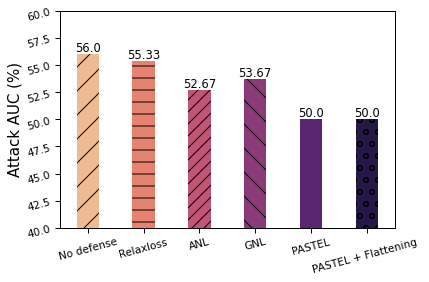

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


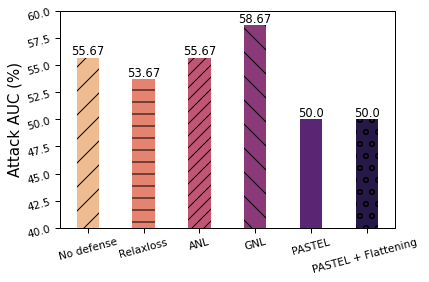

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


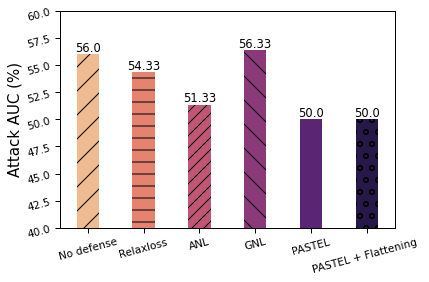

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


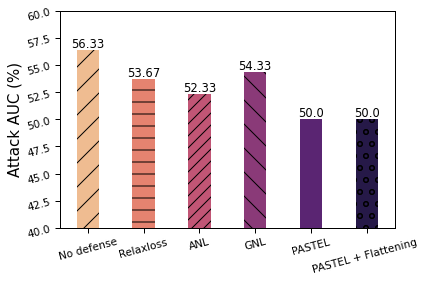

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


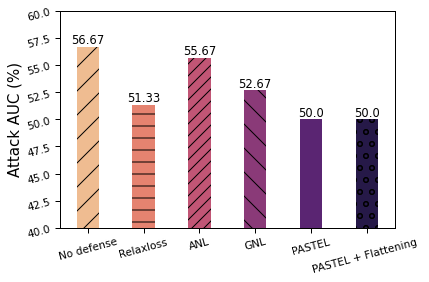

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


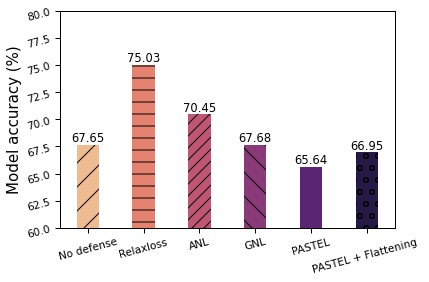

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


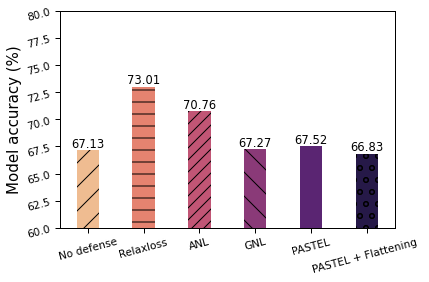

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


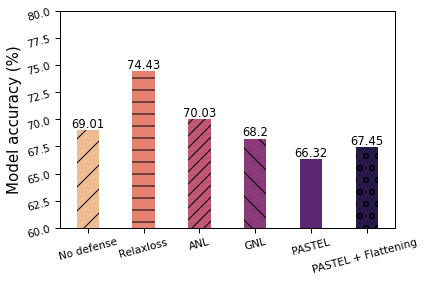

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


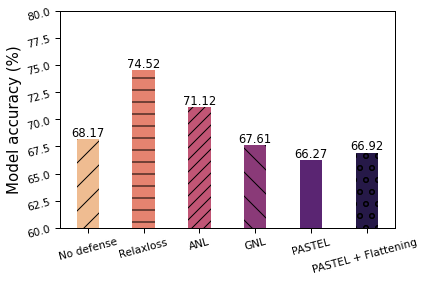

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


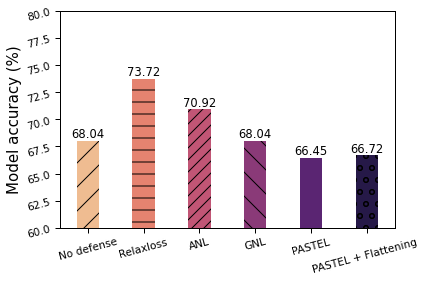

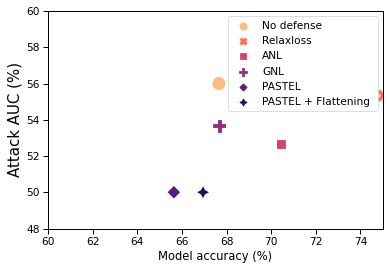

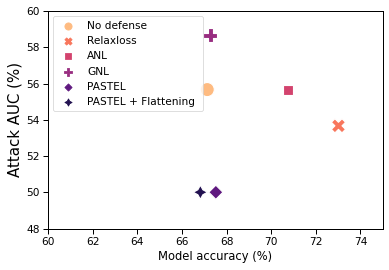

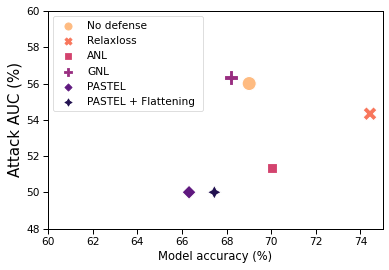

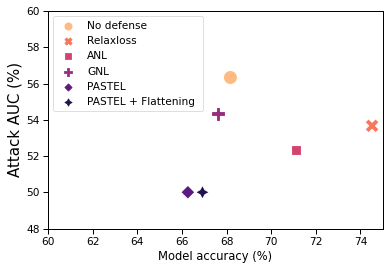

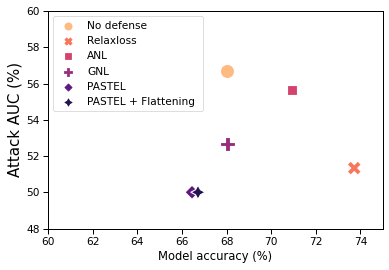

In [27]:
generate_histogram(plot_config, "local_model_attack_accuracy_hist", "Attack AUC (%)", "client_auc", 40, 60, average=True)
generate_histogram(plot_config, "global_model_attack_accuracy_hist", "Attack AUC (%)", "server_attack", 40, 60, average=True)
#generate_xy_plot(plot_config, 'local_models_attack_accuracy', 'Attack AUC (%)', 'client_auc', 0, 100, average=True)
#generate_xy_plot(plot_config, 'global_model_attack_accuracy', 'Attack AUC (%)', 'server_attack', 0, 100, average=True)
#generate_xy_plot(plot_config, 'local_models_accuracy', 'Model accuracy (%)', 'client_accuracy', 0, 100, average=True)
generate_histogram(plot_config, "local_models_accuracy_hist", "Model accuracy (%)", "client_accuracy", 60, 80, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy', 'client_auc', 48, 65, 60, 75, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_server', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy', 'server_attack', 48, 65, 60, 75, average=True)

generate_histogram(plot_config, "local_model_0_attack_accuracy_hist", "Attack AUC (%)", "client_auc_0", 40, 60, average=True, extension = "png")
generate_histogram(plot_config, "local_model_1_attack_accuracy_hist", "Attack AUC (%)", "client_auc_1", 40, 60, average=True, extension = "png")
generate_histogram(plot_config, "local_model_2_attack_accuracy_hist", "Attack AUC (%)", "client_auc_2", 40, 60, average=True, extension = "png")
generate_histogram(plot_config, "local_model_3_attack_accuracy_hist", "Attack AUC (%)", "client_auc_3", 40, 60, average=True, extension = "png")
generate_histogram(plot_config, "local_model_4_attack_accuracy_hist", "Attack AUC (%)", "client_auc_4", 40, 60, average=True, extension = "png")


generate_histogram(plot_config, "local_model_0_accuracy_hist", "Model accuracy (%)", "client_accuracy_0", 60, 80, average=True, extension = "png")
generate_histogram(plot_config, "local_model_1_accuracy_hist", "Model accuracy (%)", "client_accuracy_1", 60, 80, average=True, extension = "png")
generate_histogram(plot_config, "local_model_2_accuracy_hist", "Model accuracy (%)", "client_accuracy_2", 60, 80, average=True, extension = "png")
generate_histogram(plot_config, "local_model_3_accuracy_hist", "Model accuracy (%)", "client_accuracy_3", 60, 80, average=True, extension = "png")
generate_histogram(plot_config, "local_model_4_accuracy_hist", "Model accuracy (%)", "client_accuracy_4", 60, 80, average=True, extension = "png")

generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client1', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy_0', 'client_auc_0', 48, 60, 60, 75, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client2', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy_1', 'client_auc_1', 48, 60, 60, 75, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client3', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy_2', 'client_auc_2', 48, 60, 60, 75, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client4', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy_3', 'client_auc_3', 48, 60, 60, 75, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client5', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy_4', 'client_auc_4', 48, 60, 60, 75, average=True)


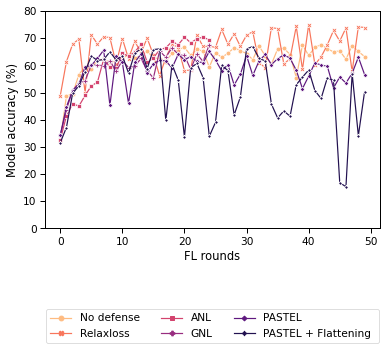

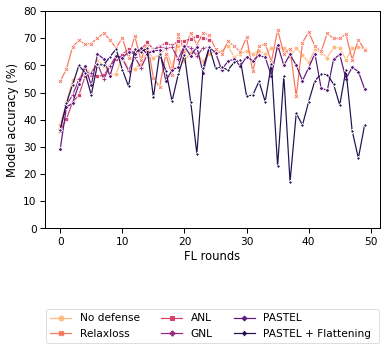

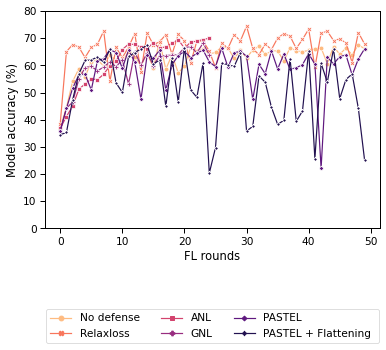

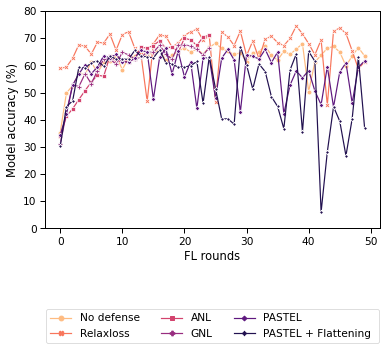

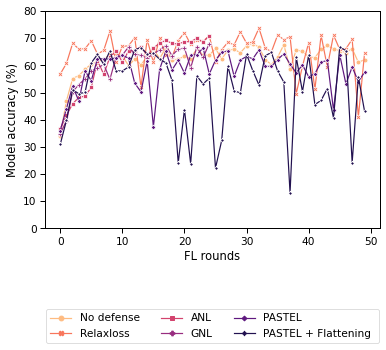

In [28]:
plot_xy(plot_config, 'client_accuracy_0', 'Model accuracy (%)', 'client_accuracy_0', 0, 80, average=True)
plot_xy(plot_config, 'client_accuracy_1', 'Model accuracy (%)', 'client_accuracy_1', 0, 80, average=True)
plot_xy(plot_config, 'client_accuracy_2', 'Model accuracy (%)', 'client_accuracy_2', 0, 80, average=True)
plot_xy(plot_config, 'client_accuracy_3', 'Model accuracy (%)', 'client_accuracy_3', 0, 80, average=True)
plot_xy(plot_config, 'client_accuracy_4', 'Model accuracy (%)', 'client_accuracy_4', 0, 80, average=True)

### GTSRB - ResNet

In [29]:
plot_config = {
                "dataset_name": "GTSRB_resnet",
                "dataset_pretty_name" : "GTSRB_ResNet",

                "data":[

                        {
                            "exp_name" : "No defense",
                            "file_path": "ppm_baseline_gtsrb_resnet.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
                                                          {
                            "exp_name" : "Relaxloss",
                            "file_path": "ppm_relaxloss03_gtsrb_resnet.csv",
                            "color": "red",
                            "symbol" : ">"
                        },
                    
                        {
                          "exp_name" : "ANL",
                         "file_path": "ppm_anl_gtsrb_resnet.csv",
                         "color": "magenta",
                         "symbol" : "X"
                        },

                        {
                            "exp_name" : "GNL",
                            "file_path": "ppm_gnl_gtsrb_resnet.csv",
                            "color": "lime",
                            "symbol" : "H"
                        },

                         {
                            "exp_name" : "PASTEL",
                            "file_path": "ppm_last-bn_gtsrb_resnet.csv",
                            "color": "grey",
                            "symbol" : "*"
                        },
                           
                            {
                            "exp_name" : "PASTEL + Flattening ",
                            "file_path": "ppm_posterior_flattening_relaxloss_uniform_gtsrb_resnet.csv",
                            "color": "brown",
                            "symbol" : "x"
                        }
                    ]
                }

[1.1495474547669933, 0.27677850200939563, 0.8932987740588615, 1.9782080677979188, 0.0, 0.0]


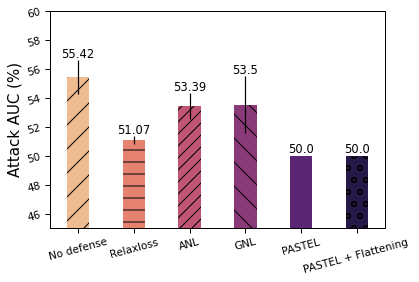

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


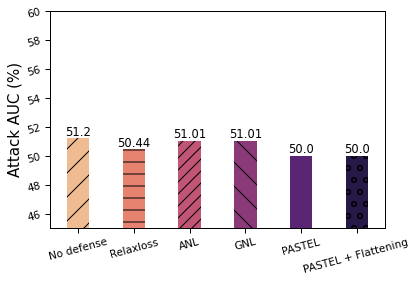

[0.1312155622624147, 0.8309940989893247, 0.10097963024856009, 0.05199430941364884, 0.2466202449054177, 0.012417196950915808]


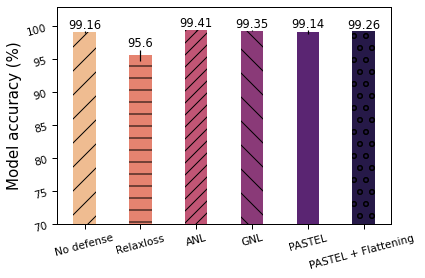

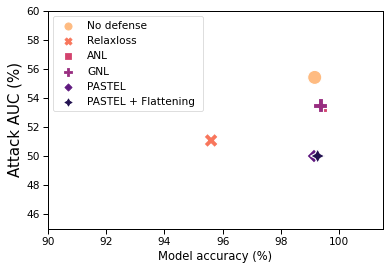

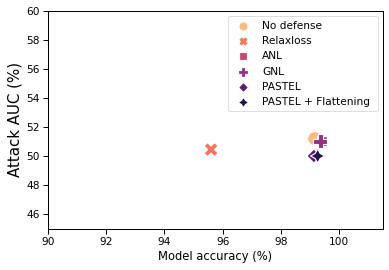

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


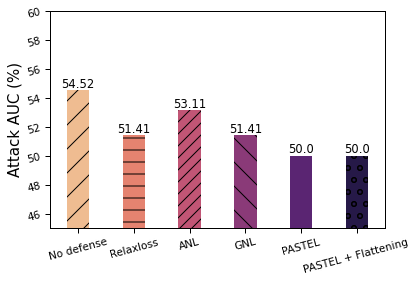

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


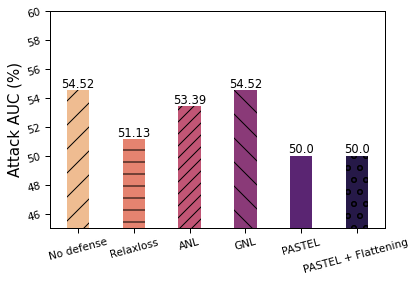

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


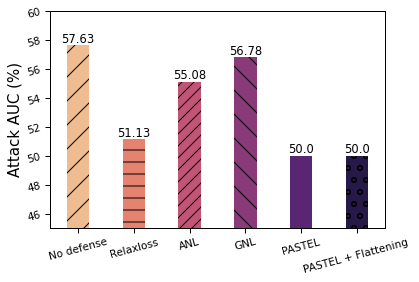

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


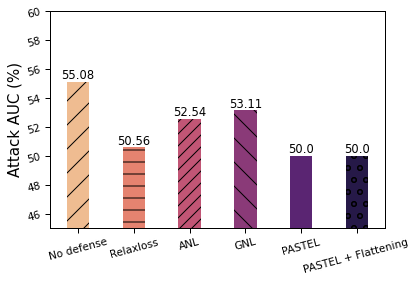

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


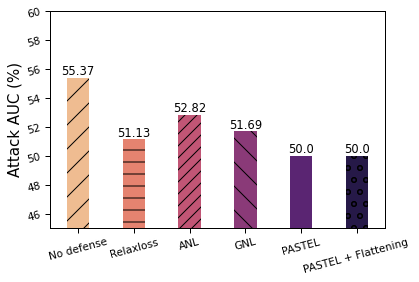

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


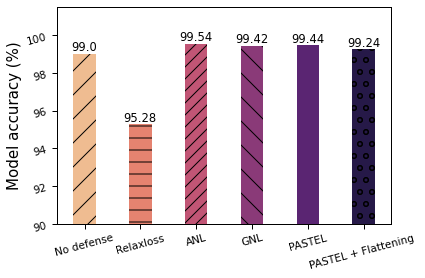

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


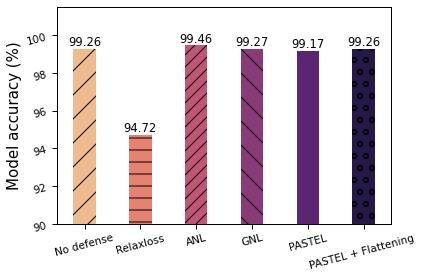

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


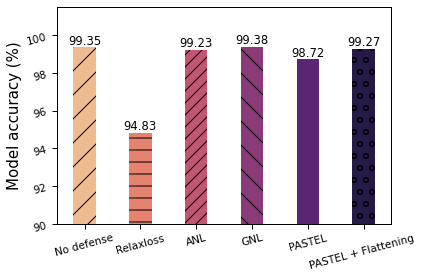

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


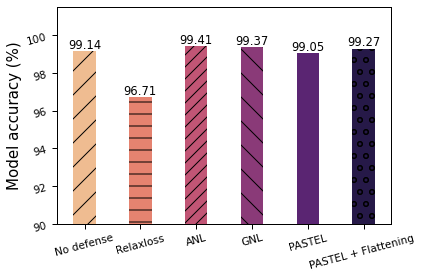

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


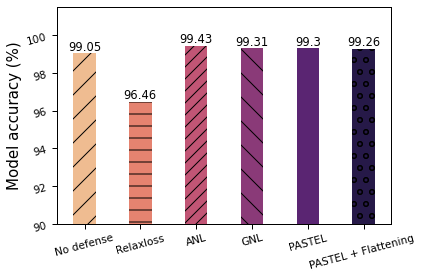

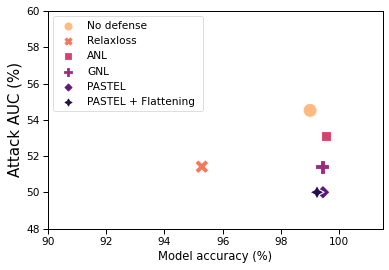

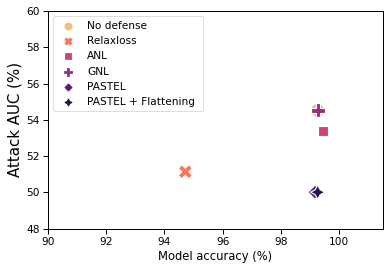

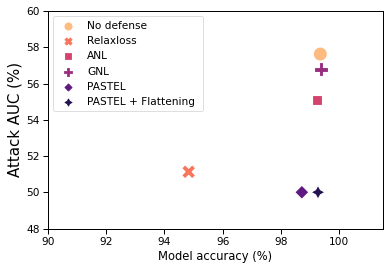

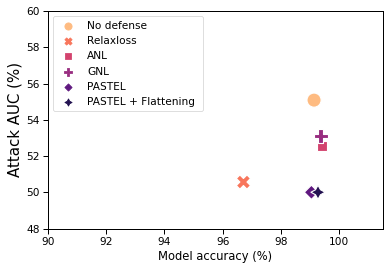

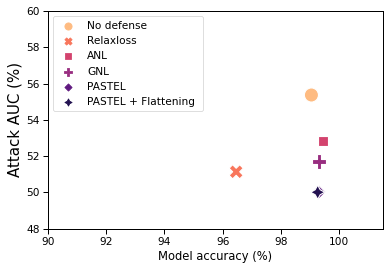

In [30]:
generate_histogram(plot_config, "local_model_attack_accuracy_hist", "Attack AUC (%)", "client_auc", 45, 60, average=True)
generate_histogram(plot_config, "global_model_attack_accuracy_hist", "Attack AUC (%)", "server_attack", 45, 60, average=True)
generate_histogram(plot_config, "local_models_accuracy_hist", "Model accuracy (%)", "client_accuracy", 70, 103, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy', 'client_auc', 45, 60, 90, 101.5, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_server', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy', 'server_attack', 45, 60, 90, 101.5, average=True)

generate_histogram(plot_config, "local_model_0_attack_accuracy_hist", "Attack AUC (%)", "client_auc_0", 45, 60, average=True, extension = "png")
generate_histogram(plot_config, "local_model_1_attack_accuracy_hist", "Attack AUC (%)", "client_auc_1", 45, 60, average=True, extension = "png")
generate_histogram(plot_config, "local_model_2_attack_accuracy_hist", "Attack AUC (%)", "client_auc_2", 45, 60, average=True, extension = "png")
generate_histogram(plot_config, "local_model_3_attack_accuracy_hist", "Attack AUC (%)", "client_auc_3", 45, 60, average=True, extension = "png")
generate_histogram(plot_config, "local_model_4_attack_accuracy_hist", "Attack AUC (%)", "client_auc_4", 45, 60, average=True, extension = "png")


generate_histogram(plot_config, "local_model_0_accuracy_hist", "Model accuracy (%)", "client_accuracy_0", 90, 101.5, average=True, extension = "png")
generate_histogram(plot_config, "local_model_1_accuracy_hist", "Model accuracy (%)", "client_accuracy_1", 90, 101.5, average=True, extension = "png")
generate_histogram(plot_config, "local_model_2_accuracy_hist", "Model accuracy (%)", "client_accuracy_2", 90, 101.5, average=True, extension = "png")
generate_histogram(plot_config, "local_model_3_accuracy_hist", "Model accuracy (%)", "client_accuracy_3", 90, 101.5, average=True, extension = "png")
generate_histogram(plot_config, "local_model_4_accuracy_hist", "Model accuracy (%)", "client_accuracy_4", 90, 101.5, average=True, extension = "png")

generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client1', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy_0', 'client_auc_0', 48, 60, 90, 101.5, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client2', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy_1', 'client_auc_1', 48, 60, 90, 101.5, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client3', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy_2', 'client_auc_2', 48, 60, 90, 101.5, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client4', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy_3', 'client_auc_3', 48, 60, 90, 101.5, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client5', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy_4', 'client_auc_4', 48, 60, 90, 101.5, average=True)


### GTSRB - VGG

In [31]:
plot_config = {
                "dataset_name": "GTSRB_vgg",
                "dataset_pretty_name" : "GTSRB_VGG",

                "data":[

                        {
                            "exp_name" : "No defense",
                            "file_path": "ppm_baseline_gtsrb_vgg.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
                              
                         {
                            "exp_name" : "Relaxloss",
                            "file_path": "ppm_relaxloss03_gtsrb_vgg.csv",
                            "color": "red",
                            "symbol" : ">"
                        },
                    
                           {
                            "exp_name" : "ANL",
                            "file_path": "ppm_anl_gtsrb_vgg.csv",
                            "color": "magenta",
                            "symbol" : "X"
                        },
                        {
                            "exp_name" : "GNL",
                            "file_path": "ppm_gnl_gtsrb_vgg.csv",
                            "color": "lime",
                            "symbol" : "H"
                        },

                        {
                            "exp_name" : "PASTEL",
                            "file_path": "ppm_last-bn_gtsrb_vgg.csv",
                            "color": "grey",
                            "symbol" : "*"
                        },
                           
                            {
                            "exp_name" : "PASTEL + Flattening ",
                            "file_path": "ppm_posterior_flattening_relaxloss_uniform_gtsrb_vgg.csv",
                            "color": "brown",
                            "symbol" : "x"
                        }
                    
                    ]
                }

[1.324976203339955, 1.6759770592306582, 1.6702537287112398, 2.6535635176988404, 1.6217740219669288, 0.0]


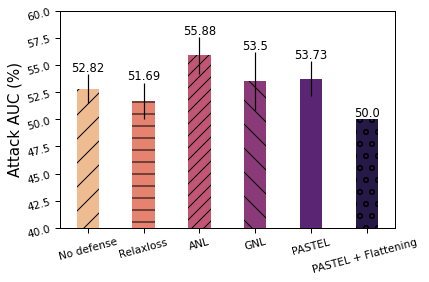

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


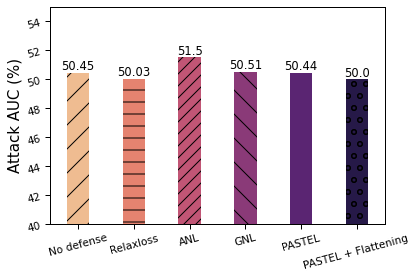

[0.17419517308817195, 1.0955208717325107, 0.5761603970161269, 0.18300100721478482, 0.2852353840408278, 0.18867058056280633]


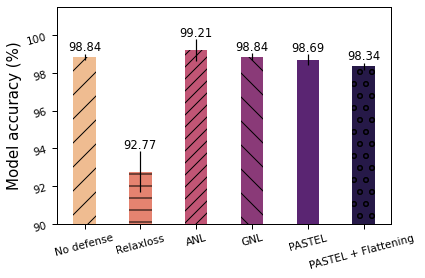

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


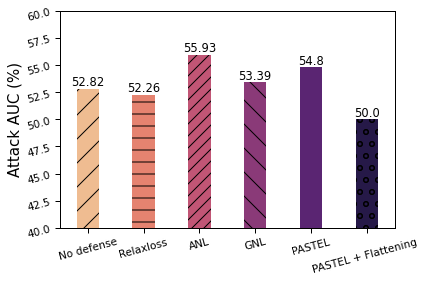

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


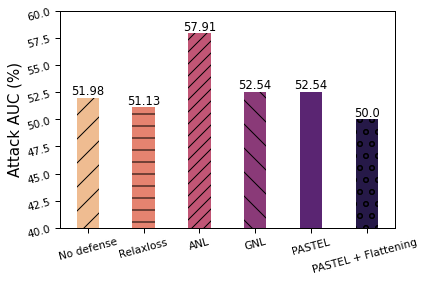

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


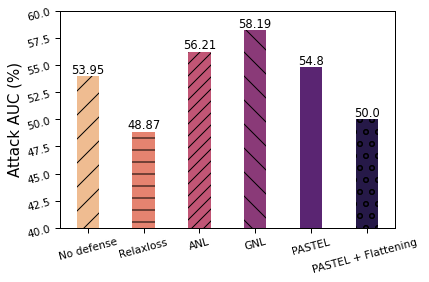

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


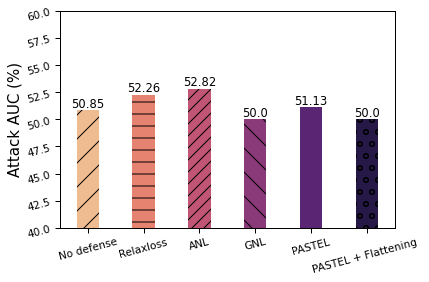

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


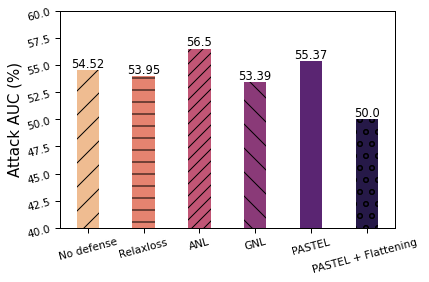

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


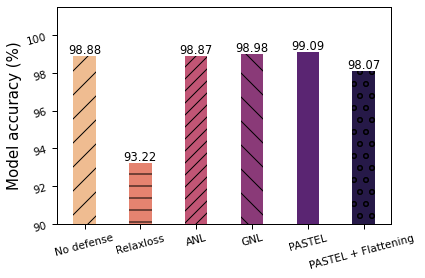

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


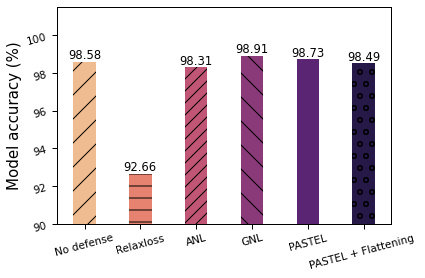

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


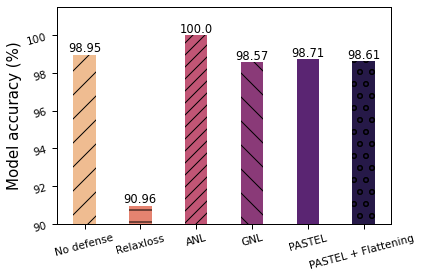

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


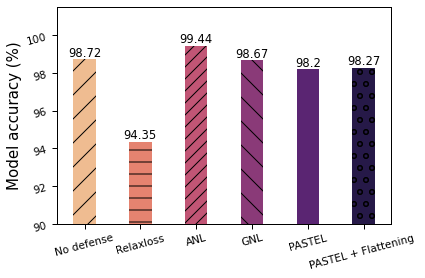

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


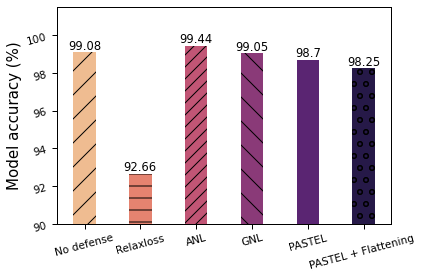

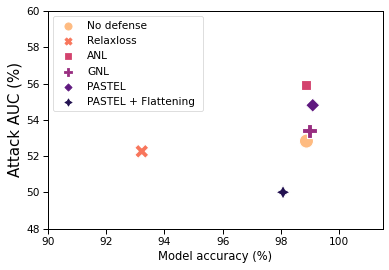

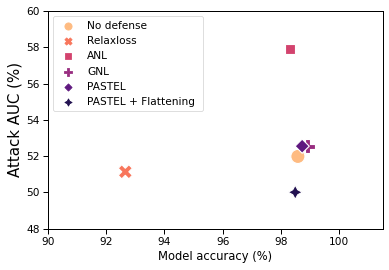

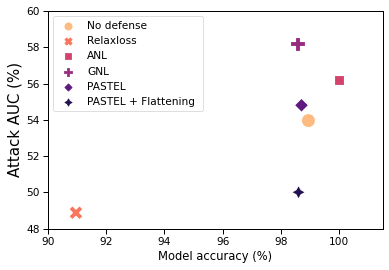

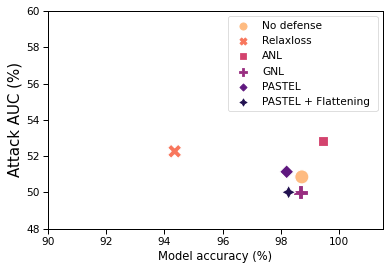

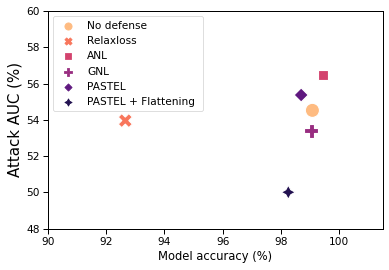

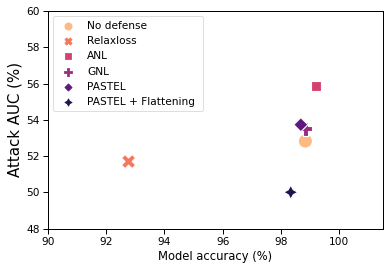

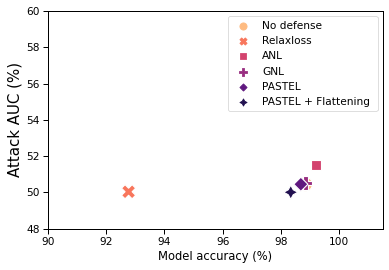

In [32]:
generate_histogram(plot_config, "local_model_attack_accuracy_hist", "Attack AUC (%)", "client_attack", 40, 60, average=True)
generate_histogram(plot_config, "global_model_attack_accuracy_hist", "Attack AUC (%)", "server_attack", 40, 55, average=True)

generate_histogram(plot_config, "local_models_accuracy_hist", "Model accuracy (%)", "client_accuracy", 90, 101.5, average=True)

generate_histogram(plot_config, "local_model_0_attack_accuracy_hist", "Attack AUC (%)", "client_attack_0", 40, 60, average=True, extension = "png")
generate_histogram(plot_config, "local_model_1_attack_accuracy_hist", "Attack AUC (%)", "client_attack_1", 40, 60, average=True, extension = "png")
generate_histogram(plot_config, "local_model_2_attack_accuracy_hist", "Attack AUC (%)", "client_attack_2", 40, 60, average=True, extension = "png")
generate_histogram(plot_config, "local_model_3_attack_accuracy_hist", "Attack AUC (%)", "client_attack_3", 40, 60, average=True, extension = "png")
generate_histogram(plot_config, "local_model_4_attack_accuracy_hist", "Attack AUC (%)", "client_attack_4", 40, 60, average=True, extension = "png")


generate_histogram(plot_config, "local_model_0_accuracy_hist", "Model accuracy (%)", "client_accuracy_0", 90, 101.5, average=True, extension = "png")
generate_histogram(plot_config, "local_model_1_accuracy_hist", "Model accuracy (%)", "client_accuracy_1", 90, 101.5, average=True, extension = "png")
generate_histogram(plot_config, "local_model_2_accuracy_hist", "Model accuracy (%)", "client_accuracy_2", 90, 101.5, average=True, extension = "png")
generate_histogram(plot_config, "local_model_3_accuracy_hist", "Model accuracy (%)", "client_accuracy_3", 90, 101.5, average=True, extension = "png")
generate_histogram(plot_config, "local_model_4_accuracy_hist", "Model accuracy (%)", "client_accuracy_4", 90, 101.5, average=True, extension = "png")

generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client1', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy_0', 'client_attack_0', 48, 60, 90, 101.5, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client2', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy_1', 'client_attack_1', 48, 60, 90, 101.5, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client3', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy_2', 'client_attack_2', 48, 60, 90, 101.5, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client4', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy_3', 'client_attack_3', 48, 60, 90, 101.5, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client5', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy_4', 'client_attack_4', 48, 60, 90, 101.5, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy', 'client_attack', 48, 60, 90, 101.5, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_server', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy', 'server_attack', 48, 60, 90, 101.5, average=True)
